In [11]:
#Import packages
import matplotlib
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import math
import mpl_toolkits.mplot3d
from mpl_toolkits.mplot3d import Axes3D
import time

#Initialize values
alpha = 0.35
beta = 0.98
rho = 0.90
sigma = 0.02

A = alpha*beta
K_ss = A**(1/(1-alpha))

In [12]:
#Set up a discrete grid for K with 25 values ranging from .5K to 1.5K.
#Set up a discrete grid for z with 25 values.
#Initiatilize the policy function and value function matrices.

K_grid = np.linspace(0.5*K_ss, 1.5*K_ss, 25)
V_init = np.zeros((25,25)) #initial guess at the value function
H_init = np.zeros((25,25)) #initial guess at the policy function
V_temp = np.zeros((25,25,25)) #initialize the temporary value function for each combo going i to j
V_new = np.zeros((25,25)) #initialize the new value function
H_new = np.zeros((25,25)) #initialize the new policy function
K_grid

array([ 0.09639131,  0.10442392,  0.11245653,  0.12048914,  0.12852175,
        0.13655436,  0.14458696,  0.15261957,  0.16065218,  0.16868479,
        0.1767174 ,  0.18475001,  0.19278262,  0.20081523,  0.20884784,
        0.21688045,  0.22491306,  0.23294567,  0.24097827,  0.24901088,
        0.25704349,  0.2650761 ,  0.27310871,  0.28114132,  0.28917393])

In [13]:
def new_value(k0, k1, z, alpha=0.35):
    """Returns the added value to the left of the sum in the value function"""
    return math.log(math.exp(z)*k0**alpha - k1)

In [14]:
def rouwen(rho, mu, step, num):
    '''
    Adapted from Lu Zhang and Karen Kopecky. Python by Ben Tengelsen.
    Construct transition probability matrix for discretizing an AR(1)
    process. This procedure is from Rouwenhorst (1995), which works
    well for very persistent processes.
    INPUTS:
    rho  - persistence (close to one)
    mu   - mean and the middle point of the discrete state space
    step - step size of the even-spaced grid
    num  - number of grid points on the discretized process
    OUTPUT:
    dscSp  - discrete state space (num by 1 vector)
    transP - transition probability matrix over the grid
    '''

    # discrete state space
    dscSp = np.linspace(mu -(num-1)/2*step, mu +(num-1)/2*step, num).T

    # transition probability matrix
    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T


    while transP.shape[0] <= num - 1:

        # see Rouwenhorst 1995
        len_P = transP.shape[0]
        transP = p * np.vstack((np.hstack((transP, np.zeros((len_P, 1)))), np.zeros((1, len_P+1)))) \
                + (1 - p) * np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
                + (1 - q) * np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
                + q * np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.


    # ensure columns sum to 1
    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return transP.T, dscSp

In [15]:
mu = 0.0
rho = 0.9
step = sigma/2.4
num = 25
pi, z_grid = rouwen(rho, mu, step, num)

z_grid

array([-0.1       , -0.09166667, -0.08333333, -0.075     , -0.06666667,
       -0.05833333, -0.05      , -0.04166667, -0.03333333, -0.025     ,
       -0.01666667, -0.00833333,  0.        ,  0.00833333,  0.01666667,
        0.025     ,  0.03333333,  0.04166667,  0.05      ,  0.05833333,
        0.06666667,  0.075     ,  0.08333333,  0.09166667,  0.1       ])

In [16]:
VFmaxiter = 3000
VFiter = 0
VFtol = 1e-6
VFdist = 100

start = time.time()
while VFiter < VFmaxiter and VFdist > VFtol:
    V_star = V_new
    for i in range(len(K_grid)): #loop over current values of k
        for j in range(len(K_grid)): #loop over the next values of k
            for k in range(len(z_grid)): #loop over current values of z
                V_temp[i, j, k] = new_value(K_grid[i], K_grid[j], z_grid[k]) + beta*(np.dot(V_new[j, :], pi[:, k]))
    V_new = V_temp.max(axis=1)
    H_new = np.argmax(V_temp, axis=1)
    VFdist = (np.absolute(V_new-V_star)).max()
    if VFiter % 100 == 0:
        print(VFiter, VFdist)
    VFiter += 1
end = time.time()

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
    print('Time taken for convergence:' + str(end - start))
else:
    print('Value function did not converge', VFiter)
    print('Time taken for convergence:' + str(end - start))   
        

0 1.19528162239
100 0.132779089356
200 0.0176090296864
300 0.0023353016965
400 0.000309706673889
500 4.10731615617e-05
600 5.44710447059e-06
Value function converged after this many iterations: 685
Time taken for convergence:48.348045110702515


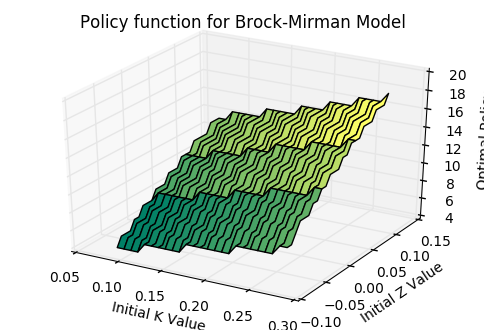

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

K_grid, z_grid = np.meshgrid(K_grid, z_grid) 

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(K_grid, z_grid, H_new, rstride=8,cstride=1, cmap=cmap1)
ax.set_title('Policy function for Brock-Mirman Model')
ax.set_xlabel('Initial K Value')
ax.set_ylabel('Initial Z Value')
ax.set_zlabel('Optimal Policy')

plt.show()